In [26]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import pre_processing as pp

### Step 0: Load Preprocessed Binary Encoded Dataset

In [27]:
# Replace with the actual path to your CSV
df = pd.read_csv(r"data/processed_data.csv")

print("Dataset shape:", df.shape)
print("Sample transactions:")
df.head()

Dataset shape: (500, 67)
Sample transactions:


,Age_Teen,Age_Young_Adult,Age_Adult,Age_Mid_Adult,Location_India,Location_US,Location_Other,Gender_Female,Gender_Male,Gaming_Daily,...,Spend_lt100,Spend_100-500,Spend_500-1000,Spend_1000plus,Reason_Fun,Reason_Stress_Relief,Reason_Skills_Competition,Reason_Socialize,Reason_Learning,Reason_Other
0,1,0,0,0,1,0,0,0,1,1,...,1,0,0,0,1,1,0,0,0,0
1,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,0,0,1,0,1,...,1,0,0,0,1,1,1,1,0,0


### Step 1: Generate Frequent Itemsets

In [28]:
MIN_SUPPORT = 0.05  # adjust based on dataset size (500+ entries recommended)

frequent_itemsets = apriori(
    df,
    min_support=MIN_SUPPORT,
    use_colnames=True
)

frequent_itemsets.sort_values(by="support", ascending=False, inplace=True)

print("\nFrequent Itemsets:")
print(frequent_itemsets)


Frequent Itemsets:
       support                                           itemsets
44       0.668                                       (Reason_Fun)
20       0.596                           (Genre_Action/Adventure)
17       0.588                                    (Device_Mobile)
7        0.536                                    (Gender_Female)
4        0.530                                   (Location_India)
...        ...                                                ...
1322     0.050  (Discovery_Gaming_Forums, Reason_Stress_Relief...
1317     0.050  (Reason_Stress_Relief, Discovery_Social_Media,...
10834    0.050  (Gender_Female, Genre_Action/Adventure, Genre_...
10833    0.050  (Gender_Female, Genre_Action/Adventure, Genre_...
10832    0.050  (Gender_Female, Genre_Action/Adventure, Genre_...

[10873 rows x 2 columns]


### Step 2: Generate Association Rules

In [29]:
MIN_CONFIDENCE = 0.5

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=MIN_CONFIDENCE
)

#### Filtering Rules

In [30]:
rules = rules.reset_index(drop=True)
rules.sort_values("confidence", ascending=False, inplace=True)

print("\nAssociation Rules Shape: ", rules.shape)

lift_filter = (rules["lift"] > 1)
confidence_filter = (rules["confidence"] >= MIN_CONFIDENCE)

filter_values = pd.DataFrame({
    "lift_filter": lift_filter,
    "confidence_filter": confidence_filter
})

# Optional: filter for meaningful rules
rules = rules[
    lift_filter & confidence_filter
]

rules
print("\nFiltered Association Rules Shape: ", rules.shape)


Association Rules Shape:  (74381, 14)

Filtered Association Rules Shape:  (71928, 14)


In [31]:
print("\nAssociation Rules:")
print(
    rules[
        ["antecedents", "consequents", "support", "confidence", "lift"]
    ].head(15)
)


Association Rules:
                                             antecedents  \
38373  (Genre_FPS, Game_Mode_Both, Genre_MMO, Discove...   
38375  (Game_Mode_Both, Genre_MMO, Discovery_Gaming_F...   
38382  (Game_Mode_Both, Discovery_Gaming_Forums, Genr...   
38384  (Game_Mode_Both, Genre_MMO, Discovery_Social_M...   
74300  (Gender_Female, Discovery_YouTube_Streaming, G...   
74301  (Gender_Female, Discovery_YouTube_Streaming, G...   
74302  (Gender_Female, Discovery_YouTube_Streaming, G...   
74304  (Gender_Female, Genre_RPG, Genre_MMO, Discover...   
38359  (Game_Mode_Both, Genre_MMO, Discovery_YouTube_...   
38360  (Game_Mode_Both, Genre_MMO, Discovery_YouTube_...   
38362  (Game_Mode_Both, Discovery_Gaming_Forums, Genr...   
38366  (Game_Mode_Both, Genre_MMO, Discovery_YouTube_...   
38371  (Genre_FPS, Game_Mode_Both, Genre_MMO, Discove...   
38478  (Game_Mode_Both, Genre_MMO, Discovery_YouTube_...   
38479  (Game_Mode_Both, Genre_MMO, Discovery_YouTube_...   

                   

### Step 3: Visualize Association Rules

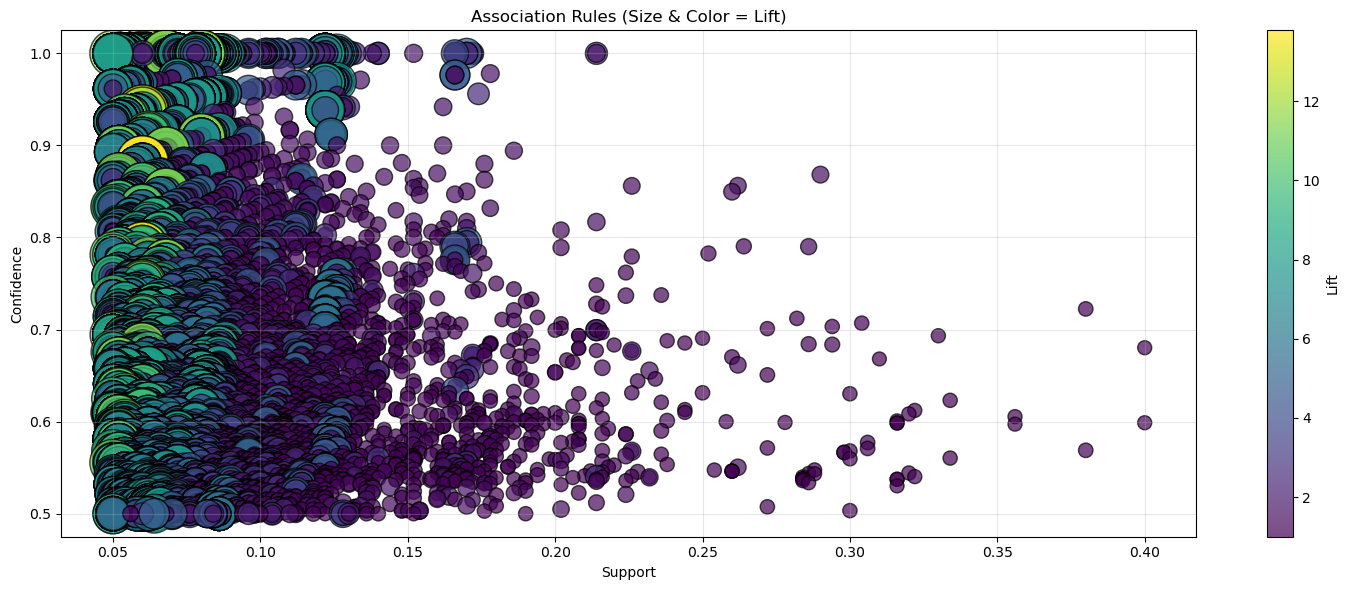

In [32]:
import matplotlib.pyplot as plt

def visualize(
    rules,
    show_labels=False,
    max_labels=15
):
    if len(rules) == 0:
        print("No association rules found with the given thresholds.")
        return

    plt.figure(figsize=(15, 6))

    scatter = plt.scatter(
        rules["support"],
        rules["confidence"],
        s=rules["lift"] * 100,
        c=rules["lift"],
        cmap="viridis",
        edgecolors="k",
        alpha=0.7
    )

    # Optional annotation toggle
    if show_labels:
        for _, row in rules.head(max_labels).iterrows():
            antecedents = ", ".join(row["antecedents"])
            consequents = ", ".join(row["consequents"])
            plt.annotate(
                f"{antecedents} → {consequents}",
                (row["support"], row["confidence"]),
                textcoords="offset points",
                xytext=(5, 5),
                fontsize=8
            )

    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.title("Association Rules (Size & Color = Lift)")
    plt.colorbar(scatter, label="Lift")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize(rules, show_labels=False, max_labels=15)

### Filter Some Rules

In [33]:
male_rules = rules[
    rules["antecedents"] == frozenset({"Gender_Male"})
]
female_rules = rules[
    rules["antecedents"] == frozenset({"Gender_Female"})
]

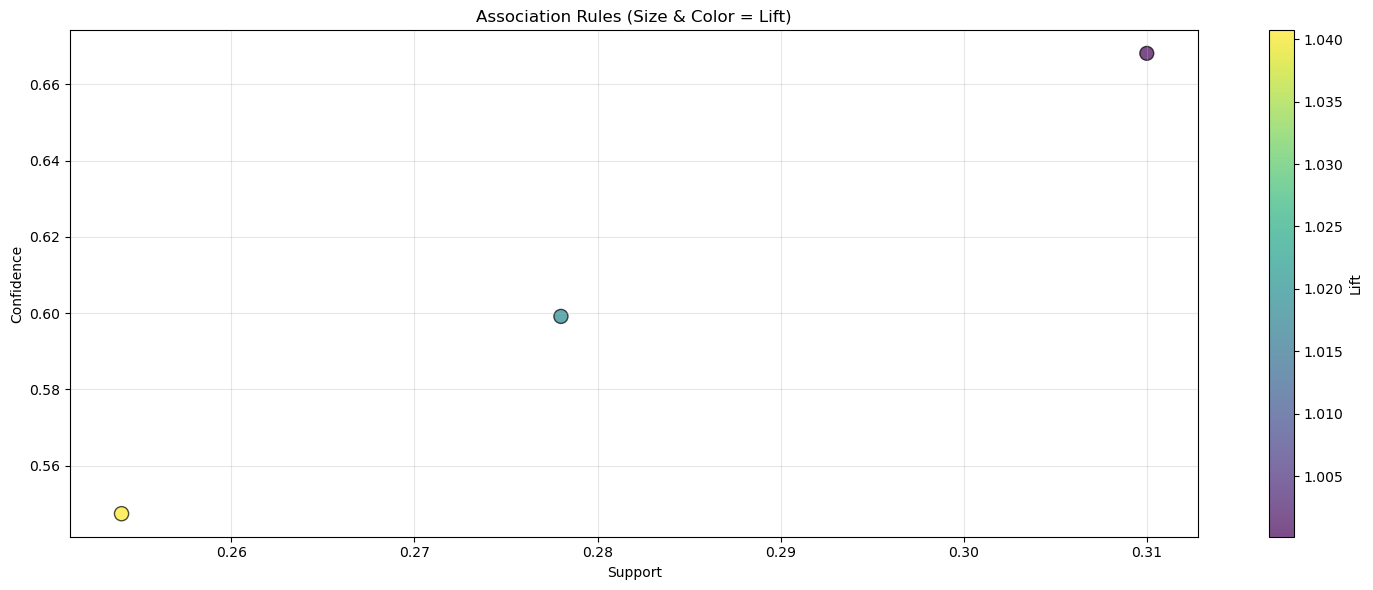

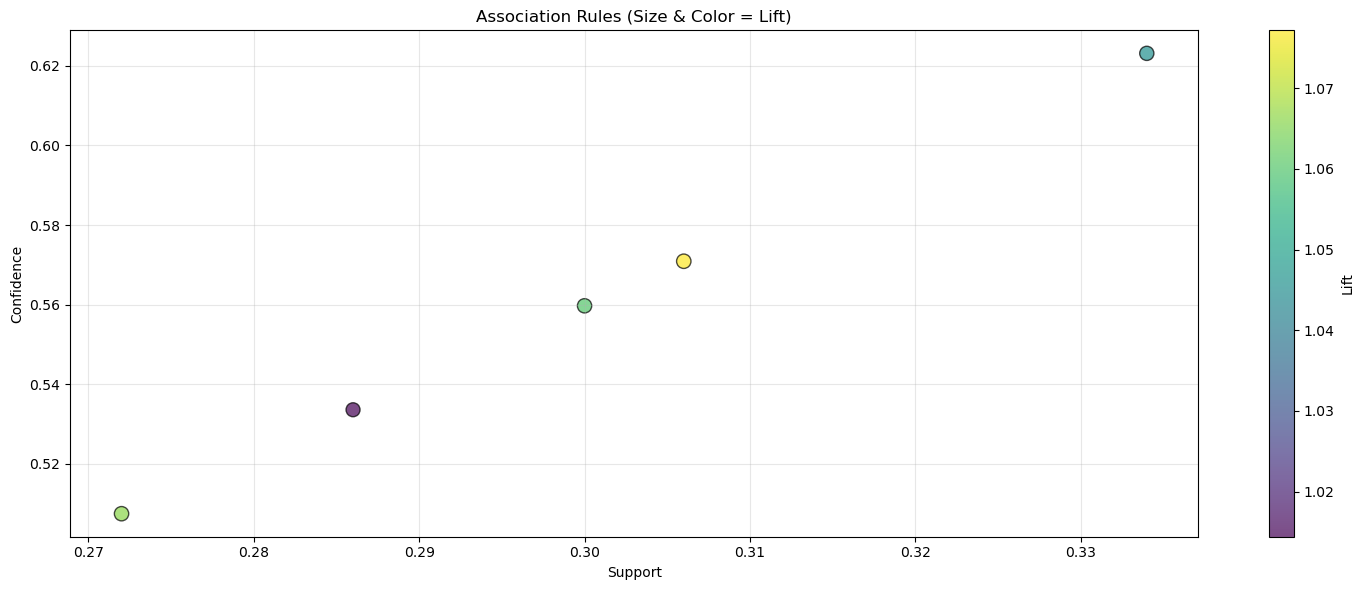

In [34]:
visualize(male_rules)
visualize(female_rules)

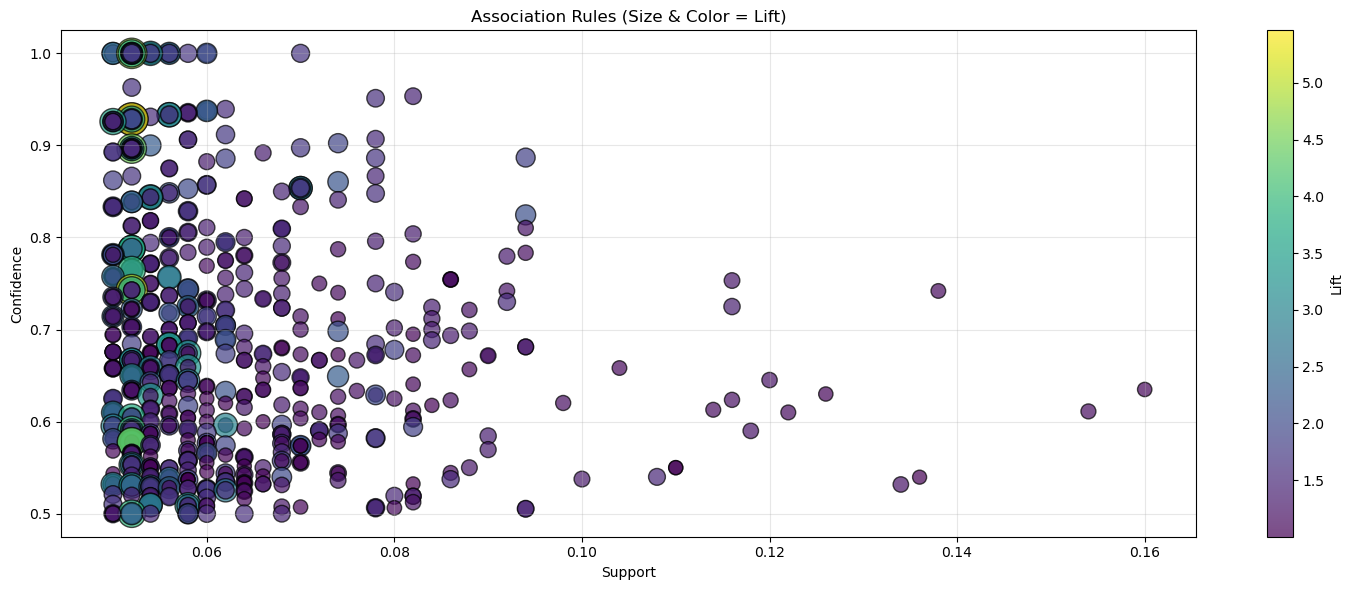

In [35]:
spending_items = {
    "Spend_100",
    "Spend_100-500",
    "Spend_500-1000",
    "Spend_1000plus",
}

spending_rules = rules[
    rules["antecedents"].apply(lambda x: not x.isdisjoint(spending_items))
]
visualize(spending_rules)